# Results synthesis

In 2022, the online store's sales climbed 28%, mainly due to a February-March sales peak and a good year-on-year stability. 

However, category 1 sales fell sharply in October 2021, despite an average price of 20.49 euros. 

First-quarter revenues came close to 1 million euros, and 2023 looks set to be even better. 

Customers have different profiles, with parity between men and women, but age is a determining factor, with 35-44 year-olds in the lead. Most customers are occasional.

## 1. Preliminary

### 1.1 Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import pearsonr, shapiro, f_oneway, ks_2samp, chi2_contingency
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt

# Options pandas
pd.options.mode.chained_assignment = None

# Constants
today = dt.date.today()
year = today.strftime("%Y")

### 1.2 Data

In [2]:
# Data Exploration
datasets_info = {
    "transactions": {"filename": "transactions.csv", "columns": ["transaction_id", "date", "client_id", "product_id", "quantity"]},
    "products": {"filename": "products.csv", "columns": ["product_id", "price", "category"]},
    "customers": {"filename": "customers.csv", "columns": ["client_id", "sex", "birth_year"]}
}

In [3]:
for dataset_name, info in datasets_info.items():
    data = pd.read_csv(info["filename"])
    print(f"Dataset {dataset_name.capitalize()}:")
    print(f"We have {data.shape[0]} entries recorded with {len(info['columns'])} different variables.")
    display(data.head())
    print("\n")

Dataset Transactions:
We have 679532 entries recorded with 5 different variables.


,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232




Dataset Products:
We have 3287 entries recorded with 3 different variables.


,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0




Dataset Customers:
We have 8623 entries recorded with 3 different variables.


,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


## 2. Data Cleaning

### 2.1 Data Formatting

In [4]:
# Transactions Date Formatting
transaction = pd.read_csv("transactions.csv")
transaction = transaction[~transaction["date"].str.contains("test_2021")]
transaction[["date", "time"]] = transaction["date"].str.split(" ", expand=True)
transaction["date"] = pd.to_datetime(transaction["date"])

In [5]:
# Products Category Formatting
product = pd.read_csv("products.csv")
product["categ"] = product["categ"].astype(str)

### 2.2 Outlier Detection

In [6]:
# Negative Price Treatment
neg_product = product[product["price"] < 0]
product.loc[product["price"] < 0, "price"] = 0

### 2.3. Merging tables

In [7]:
# Resetting index of datasets
transaction.reset_index(drop=True, inplace=True)
product.reset_index(drop=True, inplace=True)

In [8]:
# Left join of transactions with products
df_product = pd.merge(transaction, product, how="left", on="id_prod")

In [9]:
# Joining the new dataset with clients
customers = pd.read_csv("customers.csv")
df_lapage = pd.merge(df_product, customers, how="right", on="client_id")
display(df_lapage.head().round(2))

,id_prod,date,session_id,client_id,time,price,categ,sex,birth
0,0_1316,2021-12-29,s_141762,c_4410,09:11:18.860592,7.20,0,f,1967
1,1_385,2021-03-22,s_9707,c_4410,01:40:22.782925,25.99,1,f,1967
2,1_190,2021-11-12,s_118628,c_4410,18:11:43.280574,14.53,1,f,1967
3,0_1455,2021-03-22,s_9942,c_4410,14:29:25.189266,8.99,0,f,1967
4,1_483,2022-03-13,s_178686,c_4410,21:35:55.949042,15.99,1,f,1967


### 2.4 Cleaning the final join

In [10]:
# Extracting clients without transactions
clients_no_transaction = df_lapage.loc[df_lapage["id_prod"].isnull() & df_lapage["session_id"].isnull()]
clients_no_transaction["age"] = int(year) - clients_no_transaction["birth"]
print("Clients with no transactions:\n", clients_no_transaction.head())
print("Number of clients with no transactions:", clients_no_transaction.shape[0])

Clients with no transactions:
        id_prod date session_id client_id time  price categ sex  birth  age
59493      NaN  NaT        NaN    c_8253  NaN    NaN   NaN   f   2001   23
200286     NaN  NaT        NaN    c_3789  NaN    NaN   NaN   f   1997   27
218173     NaN  NaT        NaN    c_4406  NaN    NaN   NaN   f   1998   26
218174     NaN  NaT        NaN      ct_0  NaN    NaN   NaN   f   2001   23
220389     NaN  NaT        NaN    c_2706  NaN    NaN   NaN   f   1967   57
Number of clients with no transactions: 23


In [11]:
# Dropping clients with no transactions from the main dataset
df_lapage = df_lapage.dropna(subset=["id_prod"]).reset_index(drop=True)
print("\nFinal dataset after removing clients with no transactions:")
print(df_lapage.shape)


Final dataset after removing clients with no transactions:
(679332, 9)


In [12]:
# Checking for empty transactions related to the same product
empty_transactions = df_lapage.loc[df_lapage["price"].isnull() & df_lapage["categ"].isnull()]
print("\nEmpty transactions related to the same product:\n", empty_transactions.head())
print("Number of empty transactions related to the same product:", empty_transactions.shape[0])


Empty transactions related to the same product:
       id_prod       date session_id client_id             time  price categ  \
5372   0_2245 2022-01-09   s_147220    c_4505  09:23:31.000720    NaN   NaN   
5395   0_2245 2022-11-09   s_295013    c_4505  09:23:31.000720    NaN   NaN   
5968   0_2245 2021-09-11    s_88251    c_3468  10:52:05.205583    NaN   NaN   
5974   0_2245 2022-05-11   s_206902    c_3468  10:52:05.205583    NaN   NaN   
13435  0_2245 2022-09-15   s_268455    c_1403  14:26:50.187952    NaN   NaN   

      sex  birth  
5372    m   1976  
5395    m   1976  
5968    f   1981  
5974    f   1981  
13435   f   1978  
Number of empty transactions related to the same product: 221


### 2.5 Filling in the Empty Product

In [13]:
# Gender
print("\nGender Distribution for the Empty Product:")
print(empty_transactions.groupby(["sex"]).size())


Gender Distribution for the Empty Product:
sex
f    117
m    104
dtype: int64


In [14]:
# Age
birth_product_empty = empty_transactions.groupby(["birth"]).size().reset_index(name="nb_sales")
birth_product_empty["age"] = int(year) - birth_product_empty["birth"]
print("\nAverage age of buyers of this product is:", round(birth_product_empty["age"].mean(), 2), "years.")
empty_transactions.loc[:, "categ"] = '0'
empty_transactions.loc[:, "price"] = 10.64
print("\nFilled Product Information:")
print(empty_transactions.head())


Average age of buyers of this product is: 50.34 years.

Filled Product Information:
      id_prod       date session_id client_id             time  price categ  \
5372   0_2245 2022-01-09   s_147220    c_4505  09:23:31.000720  10.64     0   
5395   0_2245 2022-11-09   s_295013    c_4505  09:23:31.000720  10.64     0   
5968   0_2245 2021-09-11    s_88251    c_3468  10:52:05.205583  10.64     0   
5974   0_2245 2022-05-11   s_206902    c_3468  10:52:05.205583  10.64     0   
13435  0_2245 2022-09-15   s_268455    c_1403  14:26:50.187952  10.64     0   

      sex  birth  
5372    m   1976  
5395    m   1976  
5968    f   1981  
5974    f   1981  
13435   f   1978  


In [15]:
# Total revenue estimation for the empty product
total_revenue_empty_product = empty_transactions["price"].sum()
formatted_revenue = '{:,.2f}'.format(total_revenue_empty_product)
print("\nThe total revenue estimation for product 0_2245 is €", formatted_revenue)


The total revenue estimation for product 0_2245 is € 2,351.44


### 2.6 Data Organization

In [16]:
# Removing rows with empty prices from the main dataset
df_lapage = df_lapage.dropna(subset=["price"]).reset_index(drop=True)
print("Final dataset shape:", df_lapage.shape)

Final dataset shape: (679111, 9)


In [17]:
# Checking that the join has not affected the data formatting or detected outliers
print("\nData Information after Join:")
print(df_lapage.info())
print("\nDescriptive Statistics of the Data after Join:")
print(df_lapage.describe())


Data Information after Join:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679111 entries, 0 to 679110
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679111 non-null  object        
 1   date        679111 non-null  datetime64[ns]
 2   session_id  679111 non-null  object        
 3   client_id   679111 non-null  object        
 4   time        679111 non-null  object        
 5   price       679111 non-null  float64       
 6   categ       679111 non-null  object        
 7   sex         679111 non-null  object        
 8   birth       679111 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 46.6+ MB
None

Descriptive Statistics of the Data after Join:
               price          birth
count  679111.000000  679111.000000
mean       17.454773    1977.811149
std        18.328998      13.575361
min         0.620000    1929.000000
25%   

### 2.7 Age Calculation

In [18]:
# Calculate the age of each client
df_lapage["age"] = int(year) - df_lapage["birth"]
display(df_lapage.head().round(2))

,id_prod,date,session_id,client_id,time,price,categ,sex,birth,age
0,0_1316,2021-12-29,s_141762,c_4410,09:11:18.860592,7.20,0,f,1967,57
1,1_385,2021-03-22,s_9707,c_4410,01:40:22.782925,25.99,1,f,1967,57
2,1_190,2021-11-12,s_118628,c_4410,18:11:43.280574,14.53,1,f,1967,57
3,0_1455,2021-03-22,s_9942,c_4410,14:29:25.189266,8.99,0,f,1967,57
4,1_483,2022-03-13,s_178686,c_4410,21:35:55.949042,15.99,1,f,1967,57


## 3. Sales Indicators<a class="anchor" id="sous_partie4-1"></a>

In [19]:
df_lapage_sales = df_lapage[["date", "client_id", "id_prod", "price", "categ"]]

In [20]:
# Daily revenues and aggregate data monthly
monthly_revenues = df_lapage_sales.groupby(df_lapage["date"]).agg({"price": "sum"})
monthly_revenues.rename(columns={"price": "revenues"}, inplace=True)

In [21]:
# 21-day rolling average
monthly_revenues["21day_rolling_avg"] = monthly_revenues["revenues"].rolling(21).mean()
monthly_revenues = monthly_revenues.reset_index()

In [22]:
# Display the last 5 entries
display(monthly_revenues.tail().round(2))

,date,revenues,21day_rolling_avg
725,2023-02-24,15207.89,16072.70
726,2023-02-25,15761.25,16128.65
727,2023-02-26,16304.72,16137.85
728,2023-02-27,19170.81,16372.86
729,2023-02-28,18105.15,16367.53


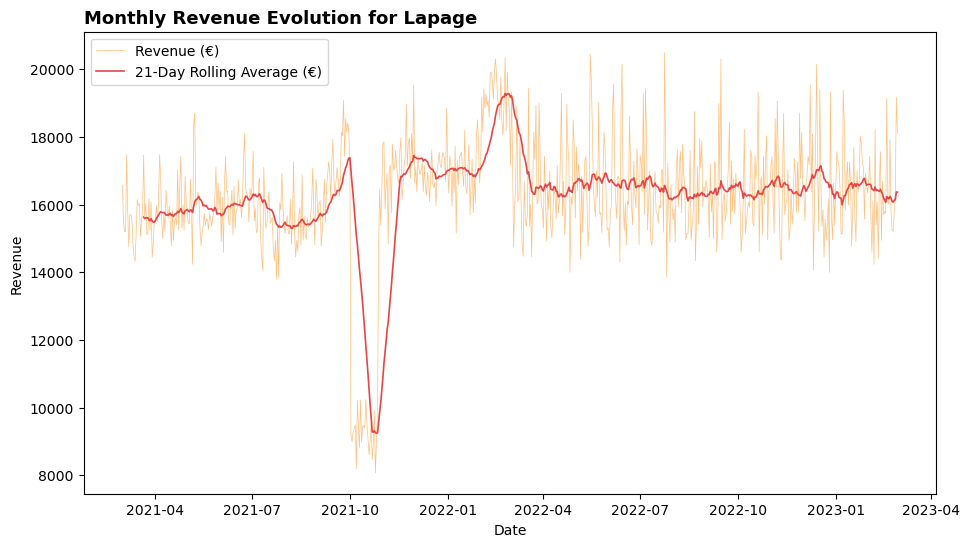

In [23]:
# Plot monthly revenue evolution
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(monthly_revenues["date"], monthly_revenues["revenues"], color="#FFC07D", linewidth=0.5)
ax.plot(monthly_revenues["date"], monthly_revenues["21day_rolling_avg"], color="#E74646", linewidth=1.2)

ax.set_title("Monthly Revenue Evolution for Lapage", loc='left', fontsize=13, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Revenue")
ax.legend(["Revenue (€)", "21-Day Rolling Average (€)"])

plt.show()

In [24]:
# Calculate monthly revenue and average monthly revenue
monthly_total_revenue = monthly_revenues["revenues"].sum()
average_monthly_revenue = monthly_total_revenue / 12

print(f"The average monthly revenue is €{average_monthly_revenue:.2f}")

The average monthly revenue is €987810.72


In [25]:
# Calculate the coefficient by dividing monthly revenue by the average monthly revenue
monthly_revenues["coeff"] = (monthly_revenues["revenues"] / average_monthly_revenue).round(3)
monthly_revenues = monthly_revenues.reset_index()

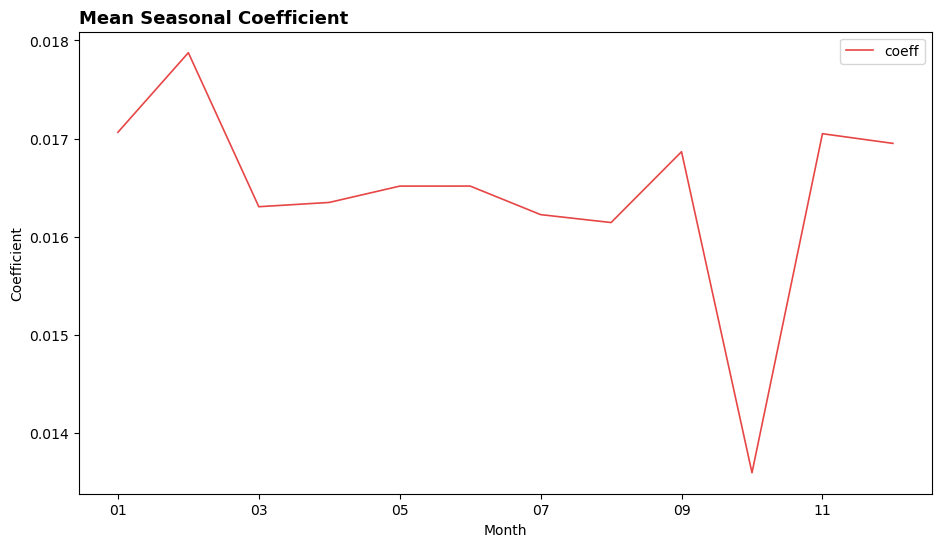

In [26]:
# Plot seasonal coefficient variation
fig, ax = plt.subplots(figsize=(11, 6))
monthly_revenues.groupby(monthly_revenues["date"].dt.strftime('%m')).agg({"coeff": "mean"}).plot(ax=ax, legend=True, color="#E74646", linewidth=1.2)
ax.set_xlabel("Month")
ax.set_ylabel("Coefficient")
ax.set_title("Mean Seasonal Coefficient", loc='left', fontsize=13, fontweight="bold")

plt.show()

We can conclude that January, October and December are the most seasonal months.

It would be better to do promotions in March, June, August and November to smooth out this curve.

### 3.1 Revenue Growth

In [27]:
changes = df_lapage_sales.groupby(df_lapage["date"].dt.to_period('Y')).agg({"price": "sum"}).pct_change() * 100
changes.rename(columns={"price": "evol"}, inplace=True)
display(changes.round(2))

,evol
date,
2021,NaN
2022,28.04
2023,-84.05


### 3.2 Total Revenue

In [28]:
total_revenue = df_lapage_sales["price"].sum()
print(f"Total online revenue is €{total_revenue:,.2f}")

Total online revenue is €11,853,728.68


In [29]:
# With the empty product estimation
total_with_empty_product = total_revenue + total_revenue_empty_product
print(f"Total online revenue, including the estimation of empty product, is €{total_with_empty_product:,.2f}")

Total online revenue, including the estimation of empty product, is €11,856,080.12


### 3.4 October 2021: Why the decrease?

In [30]:
october_sales = df_lapage_sales[(df_lapage_sales["date"] >= "2021-10-01") & (df_lapage_sales["date"] <= "2021-10-31")]
evol_revenues_october = october_sales.groupby("date").agg({"price": "sum"}).reset_index()
evol_revenues_october.rename(columns={"price": "revenues"}, inplace=True)

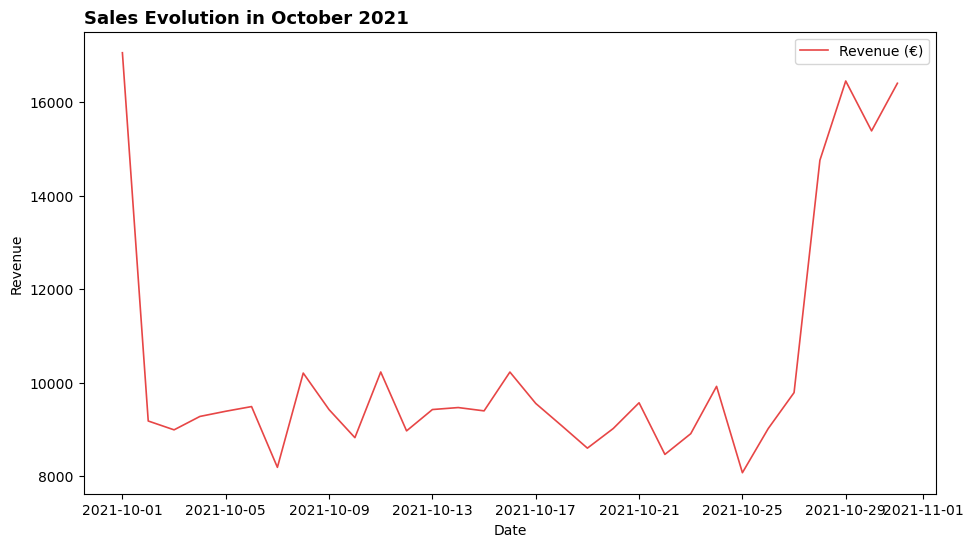

In [31]:
# Plot revenue evolution in October 2021
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(evol_revenues_october["date"], evol_revenues_october["revenues"], linewidth=1.2, color="#E74646")
ax.set_title("Sales Evolution in October 2021", loc='left', fontsize=13, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Revenue")
ax.legend(["Revenue (€)"])

plt.show()

In [32]:
# Sales by category
categ_october = october_sales.groupby(["categ"]).agg({"price": "sum", "id_prod": "count"})
categ_october.rename(columns={"id_prod": "nb_sales", "price": "revenues"}, inplace=True)
display(categ_october)

,revenues,nb_sales
categ,,
0,199250.83,18762
1,33762.32,1666
2,87785.59,1171


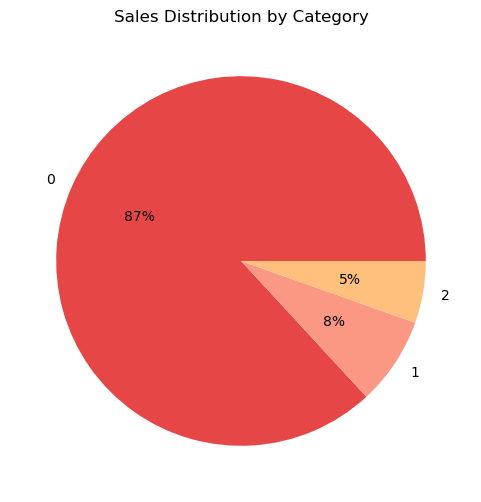

In [33]:
# Plot sales by category
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(categ_october["nb_sales"], labels=categ_october.index, autopct='%.0f%%', colors=["#E74646", "#FA9884", "#FFC07D"])
ax.set_title("Sales Distribution by Category")

plt.show()

### 3.5 Average Price per Category

In [34]:
avg_price_per_category = df_lapage_sales.groupby(["categ"]).agg({"price": "mean"})
avg_price_per_category.rename(columns={"price": "avg_price"}, inplace=True)
display(avg_price_per_category.round(2))

,avg_price
categ,
0,10.64
1,20.49
2,76.21


### 3.5 References: Tops and Flops<a class="anchor" id="sous_partie4-1-6"></a>

In [35]:
df_lapage_ref = df_lapage[["id_prod", "price", "categ"]]

In [36]:
# Top 5 most profitable references
top_profitable_references = df_lapage_ref.groupby(["id_prod", "categ"]).agg({"price": "sum", "id_prod": "count"}).sort_values("price", ascending=False).head()
top_profitable_references.rename(columns={"id_prod": "nb_sales", "price": "revenues"}, inplace=True)

display(top_profitable_references)

,,revenues,nb_sales
id_prod,categ,,
2_159,2,94893.50,650
2_135,2,69334.95,1005
2_112,2,65407.76,968
2_102,2,60736.78,1027
2_209,2,56971.86,814


In [37]:
# Top 5 least profitable references
least_profitable_references = df_lapage_ref.groupby(["id_prod", "categ"]).agg({"price": "sum", "id_prod": "count"}).sort_values("price", ascending=True).head()
least_profitable_references.rename(columns={"id_prod": "nb_sales", "price": "revenues"}, inplace=True)

display(least_profitable_references)

,,revenues,nb_sales
id_prod,categ,,
0_1539,0,0.99,1
0_1284,0,1.38,1
0_1653,0,1.98,2
0_1601,0,1.99,1
0_807,0,1.99,1


In [38]:
# Top 5 most sold references
top_sold_references = df_lapage_ref.groupby(["id_prod", "categ"]).agg(revenues=("price", "sum"), nb_sales=("id_prod", "count")).reset_index().sort_values("nb_sales", ascending=False).head()

display(top_sold_references)

,id_prod,categ,revenues,nb_sales
2591,1_369,1,54025.48,2252
2644,1_417,1,45947.11,2189
2641,1_414,1,51949.40,2180
2733,1_498,1,49731.36,2128
2653,1_425,1,35611.04,2096


In [39]:
# Top 5 least sold references
least_sold_references = df_lapage_ref.groupby(["id_prod", "categ"]).agg(revenues=("price", "sum"), nb_sales=("id_prod", "count")).reset_index().sort_values("nb_sales", ascending=True).head()

display(least_sold_references)

,id_prod,categ,revenues,nb_sales
1327,0_2201,0,20.99,1
665,0_1601,0,1.99,1
1792,0_549,0,2.99,1
3247,2_81,2,86.99,1
2079,0_807,0,1.99,1


- Category 2 generates the most revenue.
- Category 1 has the highest sales volume.
- Category 0, the most affordable one, has the least popularity.

### 3.6 Sales Distribution by Category

In [40]:
sales_by_category = df_lapage.groupby(["categ"]).agg({"price": "sum", "id_prod": "count"})
sales_by_category.rename(columns={"price": "revenues", "id_prod": "nb_sales"}, inplace=True)
display(sales_by_category)

,revenues,nb_sales
categ,,
0,4419730.97,415459
1,4653722.69,227169
2,2780275.02,36483


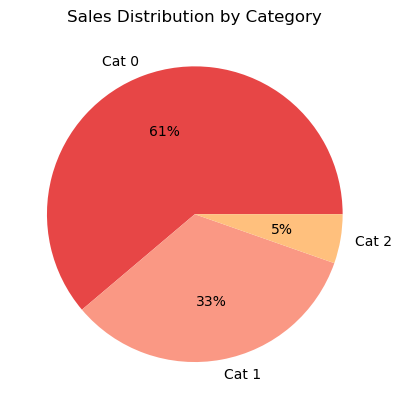

In [41]:
# Plot sales distribution by category
data_sales = sales_by_category["nb_sales"]
labels_sales = ["Cat 0", "Cat 1", "Cat 2"]
colors = ["#E74646", "#FA9884", "#FFC07D"]

plt.pie(data_sales, labels=labels_sales, autopct='%.0f%%', colors=colors)
plt.title("Sales Distribution by Category")
plt.show()

### 3.7 Revenue Distribution by Category

In [42]:
# Compute revenue distribution by category
revenue_by_category = sales_by_category["revenues"]
display(sales_by_category)

,revenues,nb_sales
categ,,
0,4419730.97,415459
1,4653722.69,227169
2,2780275.02,36483


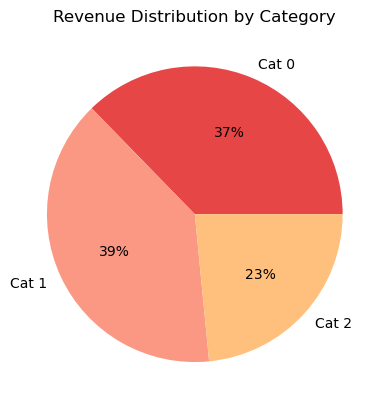

In [43]:
# Plot revenue distribution by category
data_revenue = sales_by_category["revenues"]

plt.pie(data_revenue, labels=labels_sales, autopct='%.0f%%', colors=colors)
plt.title("Revenue Distribution by Category")
plt.show()

### 3.8 Annual Revenue by Category

In [44]:
# Pivot table for annual revenue by category
annual_revenue_by_category = df_lapage.pivot_table(values=["price"], index=df_lapage["date"].dt.to_period('Y'), columns=['categ'], aggfunc=np.sum)
annual_revenue_by_category.rename(columns={"0": "Cat 0", "1": "Cat 1", "2": "Cat 2"}, inplace=True)
annual_revenue_by_category.index.names = ["Year"]
display(annual_revenue_by_category)

price                        
categ       Cat 0       Cat 1       Cat 2
Year                                     
2021   1883020.45  1777995.85  1109810.26
2022   2192970.46  2485275.19  1430436.16
2023    343740.06   390451.65   240028.60

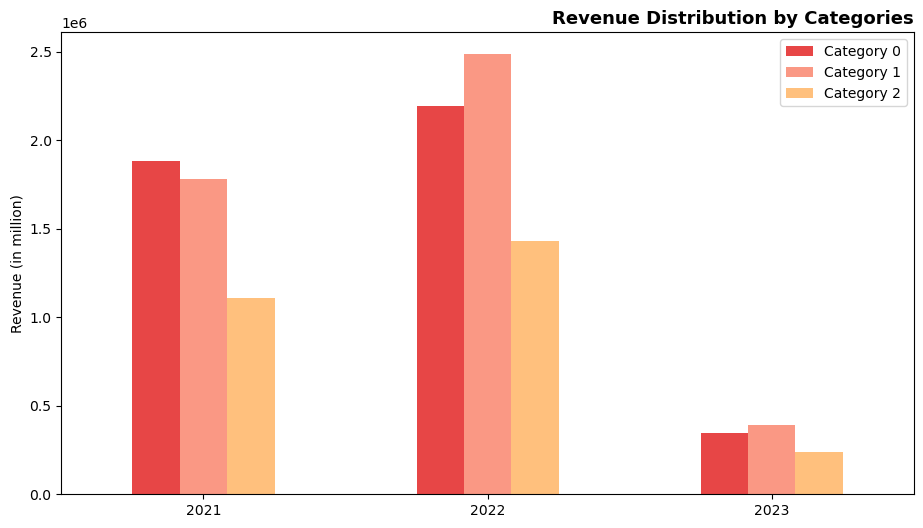

In [45]:
# Plot annual revenue by category
ax = annual_revenue_by_category.plot(kind="bar", ylabel="Revenue (in million)", xlabel="Year", width=0.5, figsize=(11, 6), color=colors)
ax.set(xlabel=None)
plt.title("Revenue Distribution by Categories", loc="right", fontsize=13, fontweight="bold")
plt.legend(["Category 0", "Category 1", "Category 2"])
plt.xticks(rotation=0)
plt.show()

In [46]:
# Analyzing average prices for each category
average_prices_by_category = df_lapage_sales.groupby(["categ"]).agg({"price": "mean"})
average_prices_by_category.rename(columns={"price": "revenues"}, inplace=True)
display(average_prices_by_category.round(2))

,revenues
categ,
0,10.64
1,20.49
2,76.21


In [47]:
# Analyzing top-selling products in category 2
products_in_category_2 = df_lapage_sales.loc[df_lapage_sales["categ"] == "2"]
products_in_category_2 = products_in_category_2.groupby(["id_prod", "price"]).agg({"id_prod": "count"})
products_in_category_2.rename(columns={"id_prod": "nb_sales"}, inplace=True)
top_10_in_category_2 = products_in_category_2.sort_values("nb_sales", ascending=False).reset_index().head(10)

In [48]:
# Compute average price of top-selling products in category 2
average_price_category_2 = top_10_in_category_2["price"].mean()
print("The average price of the top-selling products in category 2 is", round(average_price_category_2, 2), "€")

The average price of the top-selling products in category 2 is 59.48 €


In [49]:
# Analyzing the average number of sales for the top-priced products in category 2
top_10_priced_products_in_category_2 = products_in_category_2.sort_values("price", ascending=False).reset_index().head(10)
display(top_10_priced_products_in_category_2)

,id_prod,price,nb_sales
0,2_2,300.00,15
1,2_76,254.44,9
2,2_158,247.22,142
3,2_167,236.99,189
4,2_30,233.54,7
5,2_125,231.99,7
6,2_166,230.04,228
7,2_40,228.11,26
8,2_228,225.17,75
9,2_4,222.97,6


In [50]:
# Compute the average number of sales for the top-priced products in category 2
average_sales_top_priced_category_2 = top_10_priced_products_in_category_2["nb_sales"].mean()
print("The average sales of the most expensive books in category 2 is", round(average_sales_top_priced_category_2), "copies.")

The average sales of the most expensive books in category 2 is 70 copies.


## 4. Customer profiles<a class="anchor" id="sous_partie4-2"></a>

In [51]:
# Reminder: Only active clients are considered in these customer profiles
df_customers = df_lapage[["date", "client_id", "age", "sex", "id_prod", "price", "categ"]]

### 4.1 Turnover per Customer

In [52]:
# Considering each id_prod as a purchased product, we also count how many times a client made a purchase.
# Assuming there are four B2B clients: c_1609, c_4958, c_6714, and c_3454.
turnover_per_client = df_customers.groupby(["client_id", "sex", "age"]).agg({"price": "sum", "id_prod": "count"})
turnover_per_client.rename(columns={"price": "revenues", "id_prod": "nb_sales"}, inplace=True)
turnover_per_client = turnover_per_client.sort_values("revenues", ascending=False).reset_index()
display(turnover_per_client.head(10))

,client_id,sex,age,revenues,nb_sales
0,c_1609,m,44,324033.35,25488
1,c_4958,m,25,289760.34,5195
2,c_6714,f,56,153598.92,9181
3,c_3454,m,55,113637.93,6770
4,c_3263,f,39,5276.87,403
5,c_1570,f,45,5271.62,369
6,c_2899,f,30,5214.05,105
7,c_2140,f,47,5208.82,402
8,c_7319,f,50,5155.77,371
9,c_7959,f,50,5085.45,369


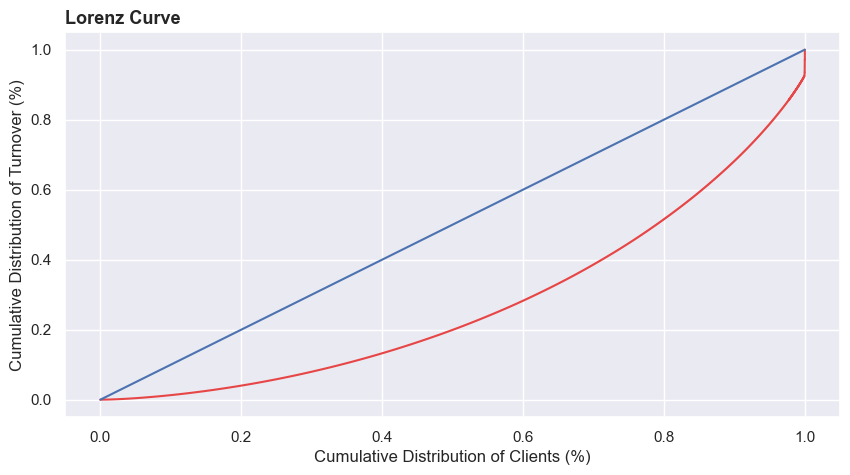

In [53]:
# Lorenz Curve
# It seems that 50% of the turnover is held by 80% of the clients.

sns.set(rc={'figure.figsize': (10, 5)})

prices = turnover_per_client["revenues"].values
n = len(prices)
lorenz = np.cumsum(np.sort(prices)) / prices.sum()
lorenz = np.append([0], lorenz) 
xaxis = np.linspace(0 - 1 / n, 1 + 1 / n, len(lorenz))

plt.plot(xaxis, lorenz, drawstyle='steps-post', color='#E74646')
plt.plot([0, 1], [0, 1])

plt.xlabel("Cumulative Distribution of Clients (%)")
plt.ylabel("Cumulative Distribution of Turnover (%)")
plt.title("Lorenz Curve", loc="left", fontsize=13, fontweight="bold")

plt.show()

In [54]:
# Gini Index
AUC = (lorenz.sum() - lorenz[-1] / 2 - lorenz[0] / 2) / n
S = 0.5 - AUC 
gini = 2 * S

print("The GINI index is", round(gini, 2))

The GINI index is 0.45


### 4.2 Relationship between Age and Total Purchase Amount

In [55]:
def relationship_age_total_purchase(df_customers):
    # Check if DataFrame is empty or has missing values
    if df_customers.empty or df_customers.isnull().values.any():
        print("Input DataFrame is empty or contains missing values.")
        return

    # Check for missing values in the 'age' column
    if df_customers['age'].isnull().any():
        print("DataFrame contains missing values in the 'age' column.")
        return

    # Total purchase amount per age
    total_purchase_amount_per_age = df_customers.groupby("age")["price"].sum().reset_index().sort_values("price", ascending=False)

    # Check if total_purchase_amount_per_age DataFrame is empty
    if total_purchase_amount_per_age.empty:
        print("No data available for total purchase amount per age.")
        return

    display(total_purchase_amount_per_age.head())

    # Plot relationship between age and total purchase amount
    plt.figure(figsize=(11, 6))
    sns.regplot(x="age", y="price", data=total_purchase_amount_per_age, color="#E74646", line_kws={"color":"#FA9884","alpha":0.7,"lw":5})
    plt.title("Total Purchase Amount by Age", loc="left", fontsize=12, fontweight="bold")
    plt.xlabel("Age")
    plt.ylabel("Amount")
    plt.legend(["Amount (€)"], loc="upper right")
    plt.show()

    # Pearson correlation
    pearson_corr, pearson_p_value = pearsonr(total_purchase_amount_per_age["age"], total_purchase_amount_per_age["price"])
    print("Pearson coefficient:", round(pearson_corr, 3))
    print("p-value:", round(pearson_p_value, 3))
    
    # Interpret the correlation strength
    if abs(pearson_corr) < 0.5:
        strength = "weak"
    elif abs(pearson_corr) >= 0.5 and abs(pearson_corr) < 0.8:
        strength = "moderate"
    else:
        strength = "strong"

    # Determine if correlation is statistically significant
    significance = "statistically significant" if pearson_p_value < 0.05 else "not statistically significant"

    # Print interpretation of correlation strength and significance
    print(f"The correlation is {strength}.")
    print(f"The correlation is {significance}.")

    # Shapiro-Wilk test for normality
    shapiro_test_stat, shapiro_p_value = shapiro(total_purchase_amount_per_age["price"])
    print("Shapiro-Wilk Test statistic:", round(shapiro_test_stat, 3))
    print("p-value:", round(shapiro_p_value, 3))
    
    # Interpret the Shapiro-Wilk test result
    if shapiro_p_value < 0.05:
        print("The data is not normally distributed.")
    else:
        print("The data is normally distributed.")

,age,price
24,44,613614.58
0,20,609013.69
5,25,489497.54
25,45,334267.72
16,36,330760.73


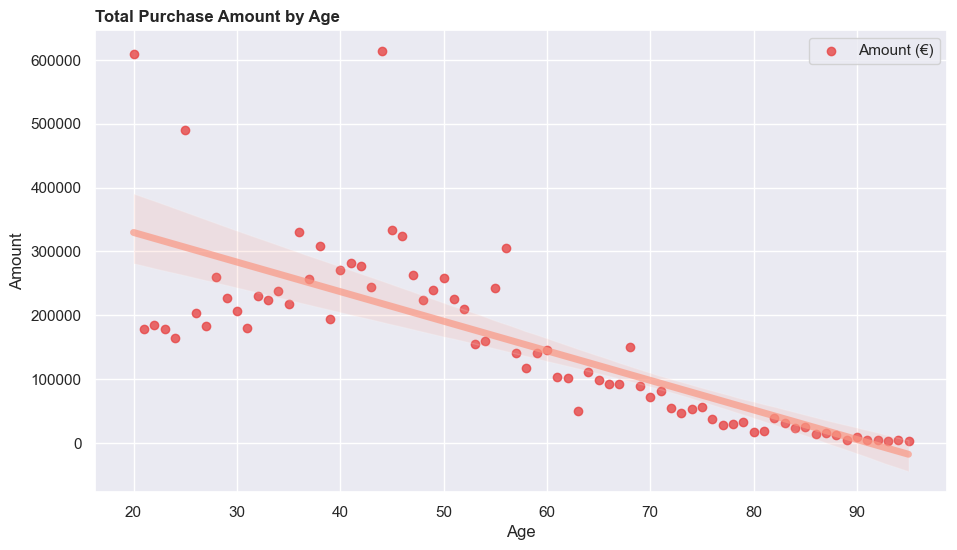

Pearson coefficient: -0.779
p-value: 0.0
The correlation is moderate.
The correlation is statistically significant.
Shapiro-Wilk Test statistic: 0.888
p-value: 0.0
The data is not normally distributed.


In [56]:
relationship_age_total_purchase(df_customers)

### 4.3 Relationship between Age and Average Basket Size

In [57]:
def relationship_age_basket(df_customers):
    # Check if DataFrame is empty or has missing values
    if df_customers.empty or df_customers.isnull().values.any():
        print("Input DataFrame is empty or contains missing values.")
        return

    # Calculate average basket size across all ages
    df_basket = df_customers.groupby(["client_id", "age"]).agg({"price": "sum", "id_prod": "count"}).reset_index()
    df_basket["basket_size"] = df_basket["price"] / df_basket["id_prod"]

    # Plot relationship between age and average basket size
    plt.figure(figsize=(11, 6))
    sns.regplot(x="age", y="basket_size", data=df_basket, color="#E74646", line_kws={"color":"#FA9884","alpha":0.7,"lw":5})
    plt.title("Average Basket Size by Age", loc="left", fontsize=13, fontweight="bold")
    plt.xlabel("Age")
    plt.ylabel("Average Basket Size (€)")
    plt.legend(["Amount (€)"], loc="upper right")
    plt.show()

    # Pearson correlation
    pearson_corr, p_value = pearsonr(df_basket["age"], df_basket["basket_size"])
    print("Pearson coefficient:", round(pearson_corr, 3))
    print("P-value:", round(p_value, 3))

    # Interpret the correlation strength
    if abs(pearson_corr) < 0.5:
        strength = "weak"
    elif abs(pearson_corr) >= 0.5 and abs(pearson_corr) < 0.8:
        strength = "moderate"
    else:
        strength = "strong"

    # Determine if correlation is statistically significant
    significance = "statistically significant" if p_value < 0.05 else "not statistically significant"

    # Print interpretation of correlation strength and significance
    print(f"The correlation is {strength}.")
    print(f"The correlation is {significance}.")

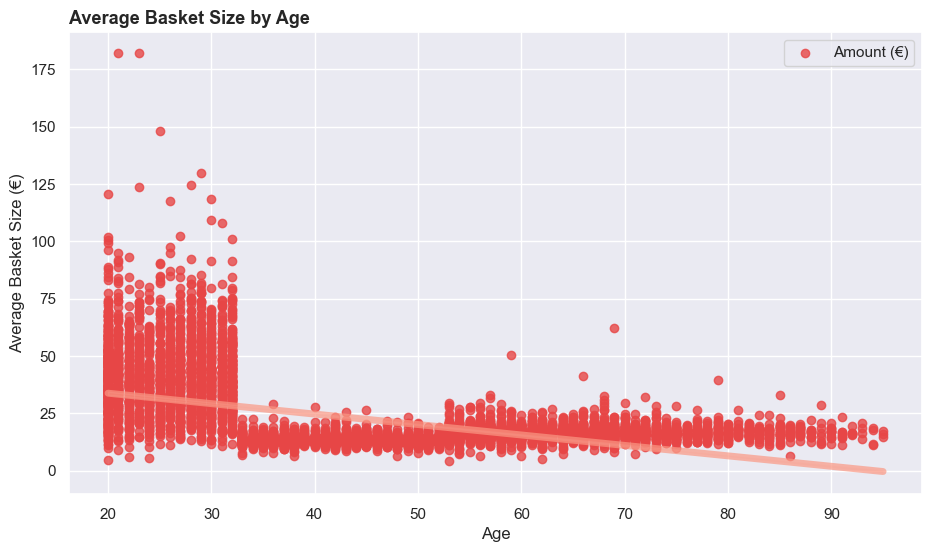

Pearson coefficient: -0.513
P-value: 0.0
The correlation is moderate.
The correlation is statistically significant.


In [58]:
relationship_age_basket(df_customers)

### 4.4 Relationship Between Age and Frequency of Purchase

In [59]:
def calculate_rfm_score(df_customers):
    """
    Calculate RFM (Recency, Frequency, Monetary) scores for customers.
    """
    # Determine the analysis date
    max_date = df_customers["date"].max()
    analysis_date = dt.datetime(max_date.year, max_date.month, max_date.day) + dt.timedelta(days=1)

    # Create RFM dataset
    rfm = df_customers.groupby(["client_id", "age"]).agg(
        {"date": lambda day: (analysis_date - day.max()).days, "id_prod": "count", "price": "sum"}
    )
    col_list = ["récence", "fréquence", "monétaire"]
    rfm.columns = col_list

    # Assign scores to RFM categories
    rfm["r"] = pd.qcut(rfm["récence"], 5, labels=[5, 4, 3, 2, 1])
    rfm["f"] = pd.qcut(rfm["fréquence"], 5, labels=[1, 2, 3, 4, 5])
    rfm["m"] = pd.qcut(rfm["monétaire"], 5, labels=[1, 2, 3, 4, 5])
    rfm["rfm_score"] = rfm["r"].astype(str) + rfm["f"].astype(str) + rfm["m"].astype(str)

    # Assign segment names based on RFM score
    seg_map = {
        r"[1-2][1-2]": "Weak",
        r"[1-2][3-4]": "Weak",
        r"[1-2]5": "Weak",
        r"3[1-2]": "Moderate",
        r"33": "Moderate",
        r"[3-4][4-5]": "Moderate",
        r"41": "Moderate",
        r"51": "Strong",
        r"[4-5][2-3]": "Strong",
        r"5[4-5]": "Strong"
    }
    rfm["segment"] = rfm["r"].astype(str) + rfm["f"].astype(str)
    rfm["segment"] = rfm["segment"].replace(seg_map, regex=True)

    # Drop unnecessary columns
    rfm = rfm.drop(columns=["récence", "fréquence", "monétaire", "r", "f", "m"]).reset_index()

    # Assign age groups to clients
    df_age_fréquence = rfm.assign(
        agegroup=pd.cut(
            rfm["age"],
            bins=[18, 25, 35, 45, 55, 65, 75, 85, 95],
            right=False,
            labels=["18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-84", "+85"]
        )
    )
    return df_age_fréquence

In [60]:
def visualize_customer_segmentation(df_age_fréquence):
    """
    Visualize the distribution of customer segments.
    """
    df_rfm = df_age_fréquence.groupby(["segment"])["client_id"].count().reset_index()
    df_rfm.rename(columns={"client_id": "nb of people"}, inplace=True)
    df_rfm["percent"] = round((df_rfm["nb of people"] / df_rfm["nb of people"].sum()) * 100, 2)

    segment_order = ["Weak", "Moderate", "Strong"]
    df_rfm["segment"] = pd.Categorical(df_rfm["segment"], categories=segment_order, ordered=True)
    df_rfm = df_rfm.sort_values("segment")

    plt.figure(figsize=(14, 6))
    sns.barplot(data=df_rfm, x="segment", y="nb of people", palette="Reds")
    plt.title("Breakdown of customers by RFM scoring", loc="left", fontsize=13, fontweight="bold")
    plt.xlabel("RFM Segments")
    plt.ylabel("Number of customers")
    plt.show()

In [61]:
def perform_chi2_test(df_frequence):
    """
    Perform Chi-square test on RFM frequencies.
    """
    resultats_test = chi2_contingency(df_frequence)
    print("Test statistics:", round(resultats_test[0], 3))
    print("p_value:", round(resultats_test[1], 3))
    print("Degrees of freedom:", resultats_test[2])
    
    if resultats_test[1] < 0.05:
        print("The p-value is less than 0.05. We reject the null hypothesis.")
        print("There is a significant relationship between gender and book categories purchased.")
    else:
        print("The p-value is greater than or equal to 0.05. We fail to reject the null hypothesis.")

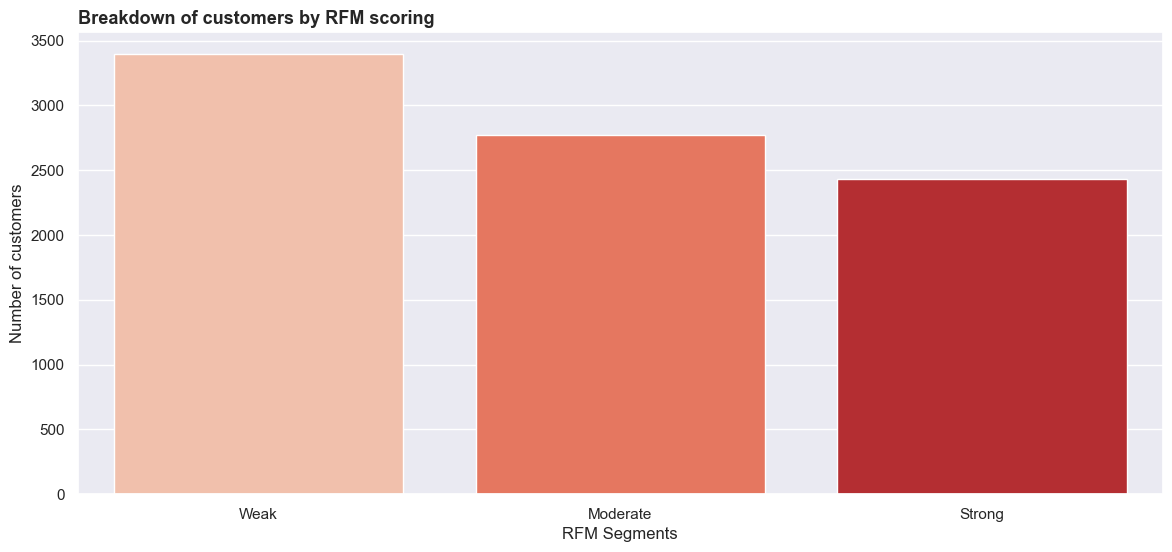

Test statistics: 329.964
p_value: 0.0
Degrees of freedom: 14
The p-value is less than 0.05. We reject the null hypothesis.
There is a significant relationship between gender and book categories purchased.


In [62]:
df_age_fréquence = calculate_rfm_score(df_lapage)
visualize_customer_segmentation(df_age_fréquence)
perform_chi2_test(df_age_fréquence.pivot_table(index="segment", columns="agegroup", values="client_id", aggfunc=len))

### 4.5 Relationship Between Age and Categories of Books Purchased

In [63]:
def plot_category_sales_by_age(df_customers):
    """
    Plot the number of sales per category by age.

    Parameters:
    - df_customers (DataFrame): DataFrame containing customer data with columns 'categ', 'age', and 'id_prod'.
    """
    df_cat_age = df_customers.groupby(["categ", "age"]).agg({"id_prod": "count"}).rename(columns={"id_prod": "nb_sales"}).reset_index()

    fig, ax = plt.subplots(figsize=(11, 6))

    colors = ["#E74646", "#FA9884", "#FFC07D"]
    labels = ["Category 0", "Category 1", "Category 2"]

    for categ, color, label in zip(range(3), colors, labels):
        age_categ = df_cat_age.query(f"categ == '{categ}'").groupby(["age"])["nb_sales"].sum().reset_index()
        ax.scatter(age_categ["age"], age_categ["nb_sales"], color=color, label=label, alpha=0.7)

    ax.set_title("Number of sales by age", loc="left", fontsize=13, fontweight="bold")
    ax.set_xlabel("Age")
    ax.set_ylabel("Number of sales")
    ax.legend(loc="upper right")

    plt.show()

In [64]:
def calculate_and_print_pearson(df_customers):
    """
    Calculate and print the Pearson correlation coefficient and p-value.
    
    Parameters:
    - df_cat_age (DataFrame): DataFrame containing columns 'age' and 'nb_sales'.
    """
    df_cat_age = df_customers.groupby(["categ", "age"]).agg({"id_prod": "count"}).rename(columns={"id_prod": "nb_sales"}).reset_index()
    
    try:
        # Extract data for correlation calculation
        list1 = df_cat_age["age"]
        list2 = df_cat_age["nb_sales"]

        # Calculate Pearson correlation
        pearson_coef, p_value = pearsonr(list1, list2)

        # Print the results
        print("Pearson correlation coefficient:", round(pearson_coef, 3))
        print("P-value:", round(p_value, 3))

        # Interpret the correlation strength
        if abs(pearson_coef) < 0.5:
            strength = "weak"
        elif abs(pearson_coef) >= 0.5 and abs(pearson_coef) < 0.8:
            strength = "moderate"
        else:
            strength = "strong"

        # Determine if correlation is statistically significant
        significance = "statistically significant" if p_value < 0.05 else "not statistically significant"

        # Print interpretation of correlation strength and significance
        print(f"The correlation is {strength}.")
        print(f"The correlation is {significance}.")
        
    except Exception as e:
        print("An error occurred while calculating Pearson correlation:", e) 

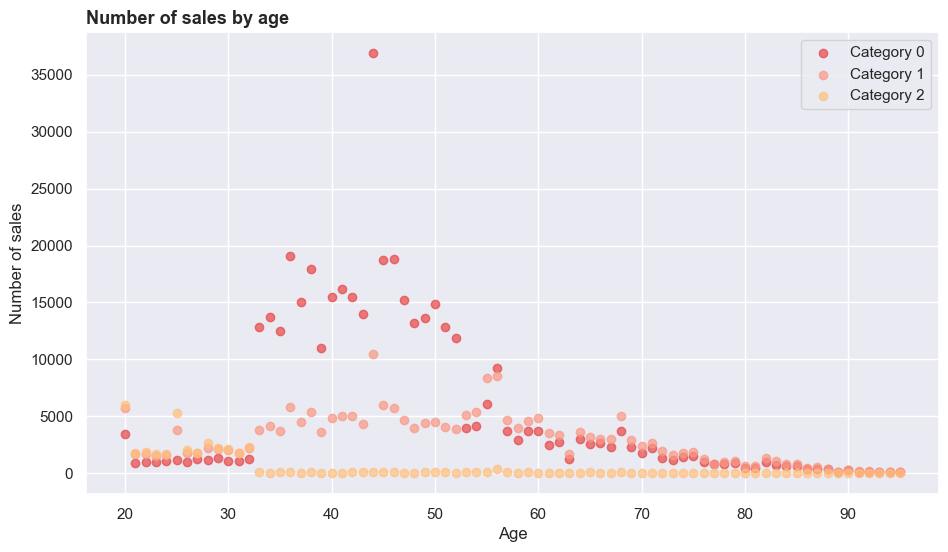

Pearson correlation coefficient: -0.325
P-value: 0.0
The correlation is weak.
The correlation is statistically significant.


In [65]:
plot_category_sales_by_age(df_customers)
calculate_and_print_pearson(df_customers)

### 4.6 Relationship Between Genre and Categories of Books Purchased

In [66]:
def analyze_genre_category_relationship(df_customers):
    """
    Analyze the relationship between gender and book categories purchased.
    
    Parameters:
    - df_client (DataFrame): DataFrame containing customer data with columns 'sex' and 'categ'.
    """
    # Cross-tabulate gender and book categories
    df_genre = pd.crosstab(index=df_customers["sex"], columns=df_customers["categ"])

    # Rename index and columns for better readability
    df_genre.rename(index={"f": "Female", "m": "Male"}, inplace=True)
    df_genre.rename(columns={"0": "Category 0", "1": "Category 1", "2": "Category 2"}, inplace=True)

    # Drop "total" row and column
    if "total" in df_genre.index:
        df_genre = df_genre.drop("total", axis=0)
    if "total" in df_genre.columns:
        df_genre = df_genre.drop("total", axis=1)

    # Plot bar chart
    ax = df_genre.plot(kind="bar", ylabel="Number of sales", width=0.5, figsize=(11,6), 
                       color=["#E74646", "#FA9884", "#FFC07D"])
    ax.set(xlabel=None)
    plt.title("Number of sales by category", loc="left", fontsize=13, fontweight="bold")
    plt.legend(["Category 0", "Category 1", "Category 2"], loc="upper right")
    plt.xticks(rotation=0)
    plt.show()

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_genre, linewidths=2, square=True, cmap='Reds', annot=True)
    plt.title("Heatmap Genders / Category of books purchased", fontweight="bold", fontsize=13)
    plt.ylabel("Genders")
    plt.xlabel("Categories")
    plt.show()

    # Chi-squared test
    chi2_stat, p_value, dof, _ = chi2_contingency(df_genre)
    print("Chi-squared statistic:", round(chi2_stat, 3))
    print("p-value:", round(p_value, 3))
    print("Degrees of freedom:", dof)
    
    if p_value < 0.05:
        print("The p-value is less than 0.05. We reject the null hypothesis.")
        print("There is a significant relationship between gender and book categories purchased.")
    else:
        print("The p-value is greater than or equal to 0.05. We fail to reject the null hypothesis.")

    # Cramer's V
    N = np.sum(df_genre.values)
    min_dimension = min(df_genre.shape) - 1
    cramer_v = np.sqrt(chi2_stat / (N * min_dimension))

    print("Cramer's V:", round(cramer_v, 3))

    if cramer_v > 0.9:
        print("The relationship between gender and book categories purchased is very strong.")
    elif cramer_v < 0.1:
        print("The relationship between gender and book categories purchased is weak.")
    else:
        print("The relationship between gender and book categories purchased is moderate.")

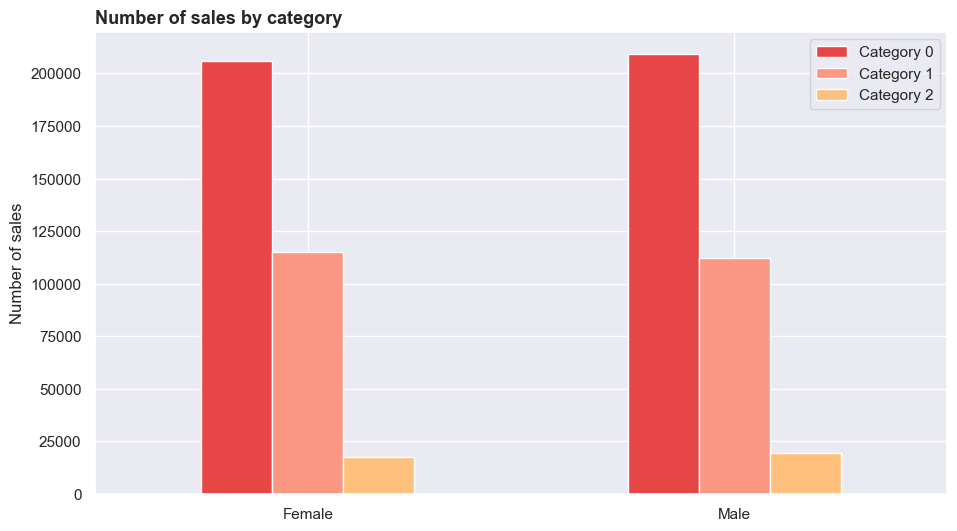

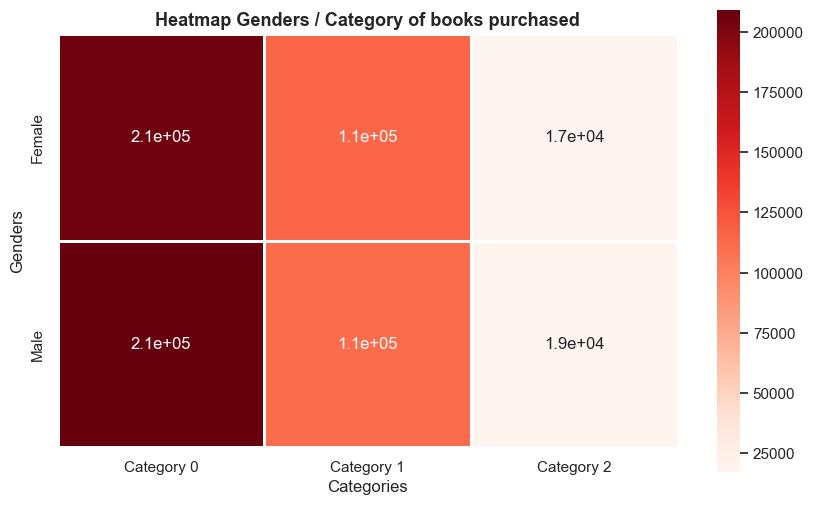

Chi-squared statistic: 147.119
p-value: 0.0
Degrees of freedom: 2
The p-value is less than 0.05. We reject the null hypothesis.
There is a significant relationship between gender and book categories purchased.
Cramer's V: 0.015
The relationship between gender and book categories purchased is weak.


In [67]:
analyze_genre_category_relationship(df_customers)